# Home Credit Default Risk (HCDR)-Predicting Borrower Behavior-Phase2 

This course project is based on a Kaggle competition. It tries to predict whether a borrower will pay or will not pay for his/her loan.
The dataset of this project is from Home Credit company, a finacial institution in Asia and East Europe.
In phase 2 of this project, we are doing feature engineering, experiments with ensemble methods, and hyperparameter tuning.

## Dataset

### Background on the dataset
Home Credit is a consumer finance provider which focuses mainly on providing financial needs to customers with little or no credit history. Founded in 1999, Home Credit has branches internationally and spread across over 9 countries. It offers financial needs to the customers such as point of sale loans, cash loans and loans for products through online and physical distribution network. Generally, customers start with POS loans and satisfied customers adopt themselves to entire business model.

Its main aim is to: 
* Focus on mass-retail lending with innovative financial methods. 
* Fulfill client’s dreams and ambitions in a financially responsible manner. 
* Provide long term and stable employment opportunities to the employers. 
* Increase the standard of living through economic development supporting domestic consumption.

It offers retail banking services such as current and deposit accounts in countries where it has banking license. It focuses on customer retention by offering cross-selling opportunities across its product base.

### Data files overview
__application_{train|test}.csv__: This is the crucial table which handles all static details about the applicants. Each row in this dataset conveys details about each loan applicant. This is furtherly classified into two different data files for training and testing. The training data includes our binary target variable (1 or 0)  and the training data obviously doesn't contain the target variable.

__bureau.csv__: This data file contains information regarding the borrower’s previous credit which was borrowed from other financial institutions and was reported to the Credit Bureau. It contains every detail of the number of credits the client previously had in the Credit Bureau before applying to loan at the Home Credit Group.

__bureau_balance.csv__: This dataset has information of borrower’s monthly credits in the previous credits. Every row in the data represents the history of previous credit reported to the Credit Bureau for every month.

__POS_CASH_balance.csv__: This data file contains monthly balance snapshots of cash loans that borrower had with Home Credit and previous point of sales. Each row has each month of history of every previous credit in Home Credit.

__credit_card_balance.csv__: This data file contains the snapshots of the history of credit cards that the borrower has with the Home credit. Each row has each month of history of every previous credit card in Home Credit.

__previous_application.csv__: This data file has all the applications that the borrower had applied for in the past.

__installments_payments.csv__: This data file has the history of the repayment that has been done for the disbursed amount in Home Credit. It has one row for every repayment that has been done and also the missed ones.

__HomeCredit_columns_description.csv__: This data file has the information about the columns in the other data files given. 


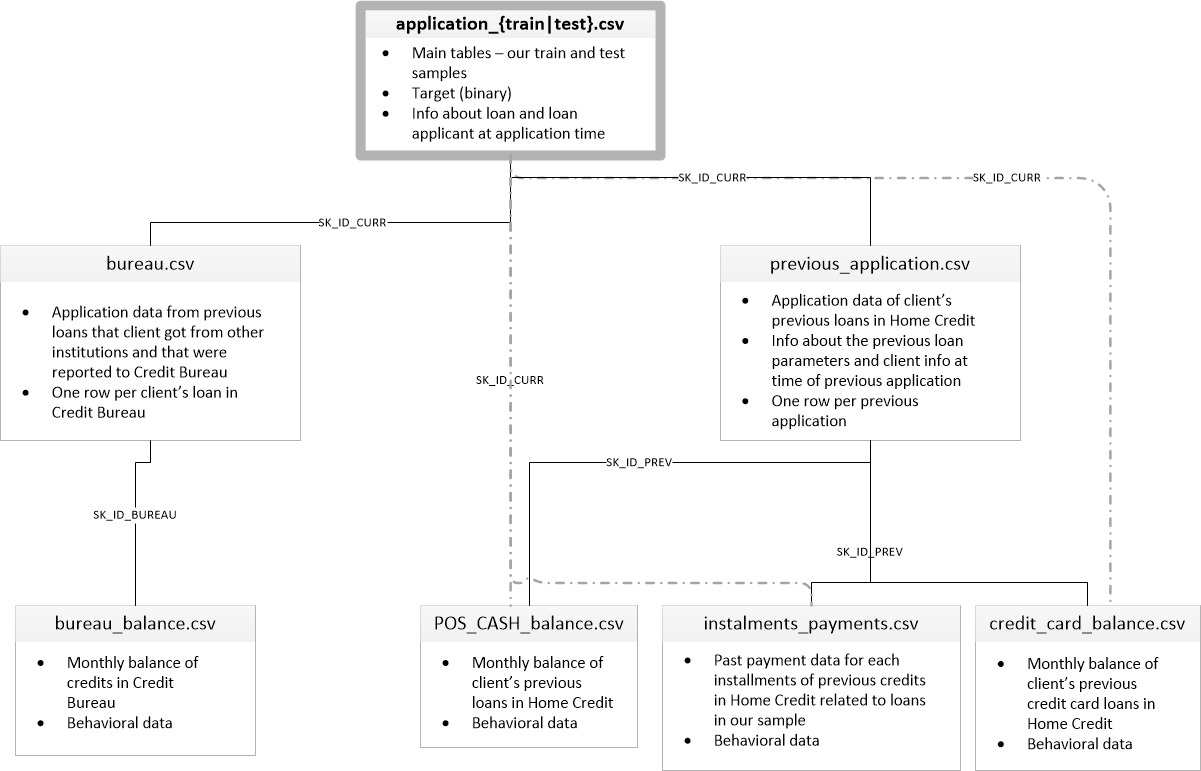

### Data Dictionary
``` 
HomeCredit_columns_description.csv
``` is a data dictionary of this dataset

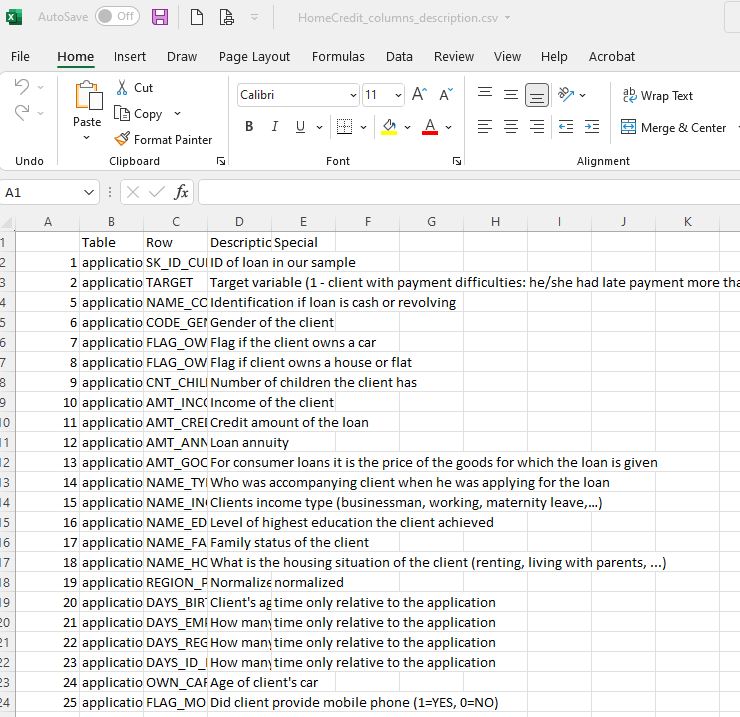

### Application train
* __application_train:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.


In [ ]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lg

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

DATA_DIR = ""
datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily
ds_name = 'application_train'
datasets[ds_name] = load_data(os.path.join(f'{ds_name}.csv'), ds_name)

datasets['application_train'].shape

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

(307511, 122)

### Application test
* __application_test:__ has the same features as application_train, except TARGET column. Kaggle does not provide the TARGET column in the test file. It is used for scoring. 


In [ ]:
ds_name = 'application_test'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

### Other tables
__bureau.csv__: This data file contains information regarding the borrower’s previous credit which was borrowed from other financial institutions and was reported to the Credit Bureau. It contains every detail of the number of credits the client previously had in the Credit Bureau before applying to loan at the Home Credit Group.

__bureau_balance.csv__: This dataset has information of borrower’s monthly credits in the previous credits. Every row in the data represents the history of previous credit reported to the Credit Bureau for every month.

__POS_CASH_balance.csv__: This data file contains monthly balance snapshots of cash loans that borrower had with Home Credit and previous point of sales. Each row has each month of history of every previous credit in Home Credit.

__credit_card_balance.csv__: This data file contains the snapshots of the history of credit cards that the borrower has with the Home credit. Each row has each month of history of every previous credit card in Home Credit.

__previous_application.csv__: This data file has all the applications that the borrower had applied for in the past.

__installments_payments.csv__: This data file has the history of the repayment that has been done for the disbursed amount in Home Credit. It has one row for every repayment that has been done and also the missed ones.

## Feature Engineering - New Features

In this section, we create 6 new features derived from tables: application_train, previous_application, and installments_payments.
 

__Work history (‘work_history’)__: days employed divided by days birth; implies how long an applicant’s work history is as a ratio of their total age. The higher the ratio, the longer the applicant has been working in their life. 

__Inc_loan ratio ('inc_loan_ratio')__: applicant’s income divided by the granted loan amount. We use this to gauge if the applicant is borrowing too much – the smaller the ratio, the more the applicant is borrowing compared to their income. 

__Previous loans ('prev_loans')__: a count of previous loans recorded by Home Credit bureau. We are curious to see the impact (positive or negative) to prediction using this feature. 

__Down payment percentage ('dwn_pymt_pct')__: Average down payment on previous Home Credit loans divided by average amount of previous Home Credit Loans received. We use this feature to gauge if higher down payments on loan will impact if an applicant defaults or not. 

__'DAYS_LATE_PAYMENT'__: the total amount of late payment of each borrower on previous Home Credit loans from the installments_payment table. The higher this number, the more likely that the borrower get default.


__'AMT_LATE_PAYMENT'__:count the number of late payment of each borrower on previous Home Credit loans from the installments_payment table. The higher this number, the more likely that the borrower struggles with the repayment


With these new features, we created our new training and test set: application_train_joined and application_test_joined


In [ ]:
DATA_DIR = "content/"
datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily
ds_name = 'application_train'
datasets[ds_name] = load_data(os.path.join(f'{ds_name}.csv'), ds_name)

datasets['application_train'].shape

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

(307511, 122)

In [ ]:
application_train = datasets['application_train']
app_train_data = application_train
print(app_train_data.shape)

(307511, 122)


### Reading Data from Previous Application File

In [ ]:
prev_apps = pd.read_csv('previous_application.csv') 

In [ ]:
prev_apps.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [ ]:
prev_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
prev_apps.describe(include='all')

SK_ID_PREV    SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  \
count   1.670214e+06  1.670214e+06            1670214  1.297979e+06   
unique           NaN           NaN                  4           NaN   
top              NaN           NaN         Cash loans           NaN   
freq             NaN           NaN             747553           NaN   
mean    1.923089e+06  2.783572e+05                NaN  1.595512e+04   
std     5.325980e+05  1.028148e+05                NaN  1.478214e+04   
min     1.000001e+06  1.000010e+05                NaN  0.000000e+00   
25%     1.461857e+06  1.893290e+05                NaN  6.321780e+03   
50%     1.923110e+06  2.787145e+05                NaN  1.125000e+04   
75%     2.384280e+06  3.675140e+05                NaN  2.065842e+04   
max     2.845382e+06  4.562550e+05                NaN  4.180581e+05   

        AMT_APPLICATION    AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count      1.670214e+06  1.670213e+06      7.743700e+05     1.284699e+06   
unique              NaN           NaN               NaN              NaN   
top                 NaN           NaN               NaN              NaN   
freq                NaN           NaN               NaN              NaN   
mean       1.752339e+05  1.961140e+05      6.697402e+03     2.278473e+05   
std        2.927798e+05  3.185746e+05      2.092150e+04     3.153966e+05   
min        0.000000e+00  0.000000e+00     -9.000000e-01     0.000000e+00   
25%        1.872000e+04  2.416050e+04      0.000000e+00     5.084100e+04   
50%        7.104600e+04  8.054100e+04      1.638000e+03     1.123200e+05   
75%        1.803600e+05  2.164185e+05      7.740000e+03     2.340000e+05   
max        6.905160e+06  6.905160e+06      3.060045e+06     6.905160e+06   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
count                     1670214             1.670214e+06  ...   
unique                          7                      NaN  ...   
top                       TUESDAY                      NaN  ...   
freq                       255118                      NaN  ...   
mean                          NaN             1.248418e+01  ...   
std                           NaN             3.334028e+00  ...   
min                           NaN             0.000000e+00  ...   
25%                           NaN             1.000000e+01  ...   
50%                           NaN             1.200000e+01  ...   
75%                           NaN             1.500000e+01  ...   
max                           NaN             2.300000e+01  ...   

       NAME_SELLER_INDUSTRY   CNT_PAYMENT  NAME_YIELD_GROUP  \
count               1670214  1.297984e+06           1670214   
unique                   11           NaN                 5   
top                     XNA           NaN               XNA   
freq                 855720           NaN            517215   
mean                    NaN  1.605408e+01               NaN   
std                     NaN  1.456729e+01               NaN   
min                     NaN  0.000000e+00               NaN   
25%                     NaN  6.000000e+00               NaN   
50%                     NaN  1.200000e+01               NaN   
75%                     NaN  2.400000e+01               NaN   
max                     NaN  8.400000e+01               NaN   

        PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
count               1669868       997149.000000  997149.000000   
unique                   17                 NaN            NaN   
top                    Cash                 NaN            NaN   
freq                 285990                 NaN            NaN   
mean                    NaN       342209.855039   13826.269337   
std                     NaN        88916.115833   72444.869708   
min                     NaN        -2922.000000   -2892.000000   
25%                     NaN       365243.000000   -1628.000000   
50%                     NaN       365243.000000    -831.000000   
75%                   

In [ ]:
## filter previous applications to NAME_CONTRACT_STATUS = 'Approved' 

prev_apps = prev_apps[prev_apps['NAME_CONTRACT_STATUS']=='Approved']


## filter prev applications to NAME_CLIENT_TYPE != XNA
prev_apps = prev_apps[prev_apps['NAME_CLIENT_TYPE']!='XNA'] ## drops 355 rows

## remove records where loan amount = 0
prev_apps = prev_apps[prev_apps['AMT_CREDIT']!=0] ## drops 980 rows ## note: AMT_APPLICATION = 0 may imply 'revolving loans'

## impute blank down payment rows with 0
prev_apps['AMT_DOWN_PAYMENT'] = prev_apps['AMT_DOWN_PAYMENT'].fillna(value=0.0)
prev_apps["AMT_DOWN_PAYMENT"] = np.where(prev_apps["AMT_DOWN_PAYMENT"] < 0, 
                                           0, prev_apps["AMT_DOWN_PAYMENT"])


#prev_apps[prev_apps['AMT_DOWN_PAYMENT'].isnull()].head()
prev_apps #108129

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
5           1383531      199383         Cash loans    23703.930   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               0.0         607500.0   
2               112500.0    136444.5               0.0         112500.0   
3               450000.0    470790.0               0.0         450000.0   
5               315000.0    340573.5               0.0         315000.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               0.0         180000.0   
1670213         360000.0    360000.0               0.0         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
0                         SATURDAY                       15  ...   
1                         THURSDAY                       11  ...   
2                          TUESDAY                       11  ...   
3                           MONDAY                        7  ...   
5                         SATURDAY                        8  ...   
...                            ...                      ...  ...   
1670209                  WEDNESDAY                       12  ...   
1670210                    TUESDAY                       15  ...   
1670211                     MONDAY                       12  ...   
1670212                  WEDNESDAY                        9  ...   
1670213                     SUNDAY                       10  ...   

         NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0                Connectivity         12.0            middle   
1                         XNA         36.0        low_action   
2                         XNA         12.0              high   
3                         XNA         12.0            middle   
5                         XNA         18.0        low_normal   
...                       ...          ...               ...   
1670209             Furniture         30.0        low_normal   
1670210             Furniture         12.0            middle   
1670211  Consumer electronics         10.0        low_normal   
1670212                   XNA         12.0        low_normal   
1670213                   XNA         48.0            middle   

                 PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0           POS mobile with interest            365243.0          -42.0   
1                   Cash X-Sell: low            365243.0         -134.0   
2                  Cash X-Sell: high            365243.0         -271.0   
3                Cash X-Sell: middle            365243.0         -482.0   
5                   Cash X-Sell: low            365243.0         -654.0   
...                              ...                 ...            ...   
1670209   POS industry with interest            365243.0         -508.0   
1670210   POS industry with interest            365243.0        -1604.0   
1670211  POS household with interest      

In [ ]:
##get average previous downpayment per current application
m = prev_apps.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean().to_frame() 
sks = list(m.index.values) ##store indexes (SK_ID's) in a list
avg_dwn_pymt = list(m['AMT_DOWN_PAYMENT'].values)


##get count of previous applications per current application
m = prev_apps.groupby('SK_ID_CURR').size().to_frame() 
m.rename(columns = {0:'Count'}, inplace = True) ## rename column to "Count"
prev_loans = list(m['Count'].values)


##get average amount of loans from previous applications per current application
m = prev_apps.groupby('SK_ID_CURR')['AMT_CREDIT'].mean().to_frame()  
avg_loan_amt = list(m['AMT_CREDIT'].values)

## create new dataframe with features engineered from the previous_application dataset
dict = {'SK_ID_prev_app': sks, 'avg_dwn_pymt': avg_dwn_pymt, 'prev_loans': prev_loans, 'prev_avg_loan_amt': avg_loan_amt} 
    
prev_apps_features = pd.DataFrame(dict)

prev_apps_features['dwn_pymt_pct'] = prev_apps_features['avg_dwn_pymt'] / prev_apps_features['prev_avg_loan_amt']

prev_apps_features['SK_ID_CURR'] = prev_apps_features['SK_ID_prev_app']
prev_apps_features = prev_apps_features.drop('SK_ID_prev_app', axis =1)

prev_apps_features

avg_dwn_pymt  prev_loans  prev_avg_loan_amt  dwn_pymt_pct  SK_ID_CURR
0            2520.00           1           23787.00      0.105940      100001
1               0.00           1          179055.00      0.000000      100002
2            2295.00           3          484191.00      0.004740      100003
3            4860.00           1           20106.00      0.241719      100004
4            4464.00           1           40153.50      0.111173      100005
...              ...         ...                ...           ...         ...
337634          0.00           1           40455.00      0.000000      456251
337635       3456.00           1           56821.50      0.060822      456252
337636       4403.25           2           20625.75      0.213483      456253
337637          0.00           2          134439.75      0.000000      456254
337638       2470.50           6          380418.00      0.006494      456255

[337639 rows x 5 columns]

In [ ]:
prev_apps_features.describe()

avg_dwn_pymt     prev_loans  prev_avg_loan_amt   dwn_pymt_pct  \
count  3.376390e+05  337639.000000       3.376390e+05  337639.000000   
mean   5.150899e+03       3.064373       1.846252e+05       0.052947   
std    1.422961e+04       2.128217       1.771468e+05       0.113700   
min    0.000000e+00       1.000000       6.183000e+03       0.000000   
25%    0.000000e+00       1.000000       7.197750e+04       0.000000   
50%    1.935000e+03       3.000000       1.272982e+05       0.012253   
75%    5.782500e+03       4.000000       2.369923e+05       0.067338   
max    1.980000e+06      27.000000       4.050000e+06       9.000000   

          SK_ID_CURR  
count  337639.000000  
mean   278138.524264  
std    102881.608022  
min    100001.000000  
25%    189047.500000  
50%    278202.000000  
75%    367299.500000  
max    456255.000000

In [ ]:
#Load application test data
app_test = pd.read_csv('application_test.csv')

In [ ]:
##standardize DAYS variables to year
app_train_data["DAYS_BIRTH"] = app_train_data["DAYS_BIRTH"]/-365
app_train_data["DAYS_EMPLOYED"] = app_train_data["DAYS_EMPLOYED"]/-365 ##55,374 entries with value = '365243' <--- impute to median/mean
app_train_data["DAYS_EMPLOYED"] = np.where(app_train_data["DAYS_EMPLOYED"] == 365243/-365, 
                                           app_train_data["DAYS_EMPLOYED"].median(), app_train_data["DAYS_EMPLOYED"])

app_train_data["DAYS_REGISTRATION"] = app_train_data["DAYS_REGISTRATION"]/-365
app_train_data["DAYS_ID_PUBLISH"] = app_train_data["DAYS_ID_PUBLISH"]/-365

In [ ]:
print(app_train_data.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


In [ ]:
app_test["DAYS_BIRTH"] = app_test["DAYS_BIRTH"]/-365
app_test["DAYS_EMPLOYED"] = app_test["DAYS_EMPLOYED"]/-365 ##55,374 entries with value = '365243' <--- impute to median/mean
app_test["DAYS_EMPLOYED"] = np.where(app_test["DAYS_EMPLOYED"] == 365243/-365, 
                                           app_test["DAYS_EMPLOYED"].median(), app_test["DAYS_EMPLOYED"])

app_test["DAYS_REGISTRATION"] = app_test["DAYS_REGISTRATION"]/-365
app_test["DAYS_ID_PUBLISH"] = app_test["DAYS_ID_PUBLISH"]/-365

In [ ]:
app_train_data['work_history'] = app_train_data['DAYS_EMPLOYED'] / app_train_data['DAYS_BIRTH']
app_train_data["work_history"] = np.where(app_train_data["work_history"] == -0, 
                                           0, app_train_data["work_history"])

app_train_data['inc_loan_ratio'] = app_train_data['AMT_INCOME_TOTAL'] / app_train_data['AMT_CREDIT']

app_train_data.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868      43.936973       5.954178  ...   
std                      0.013831      11.956133       5.930620  ...   
min                      0.000290      20.517808      -0.000000  ...   
25%                      0.010006      34.008219       2.556164  ...   
50%                      0.018850      43.150685       3.323288  ...   
75%                      0.028663      53.923288       7.561644  ...   
max                      0.072508      69.120548      49.073973  ...   

       FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
count     307511.000000     307511.000000               265992.000000   
mean           0.000507          0.000335                    0.006402   
std            0.022518          0.018299                    0.083849   
min            0.000000          0.000000                    0.000000   
25%            0.000000          0.000000                    0.000000   
50%            0.000000          0.000000                    0.000000   
75%            0.000000          0.000000                    0.000000   
max            1.000000          1.000000                    4.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count              265992.000000               265992.000000   
mean                    0.007000                    0.034362   
std                     0.110757                    0.204685   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                    0.000000   
max                     9.000000                    8.000000   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count              265992.000000              265992.000000   
mean                    0.267395                   0.265474   
std                     0.916002                   0.794056   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   0.000000   
max                    27.000000                 261.000000   

       AMT_REQ_CREDIT_BUREAU_YEAR   work_history  inc_loan_ratio  
count               265992.000000  307511.000000   307511.000000  
mean                     1.899974       0.138740        0.399670  
std                      1.869295       0.126994        0.507924  
min                      0.000000       0.000000        0.011801  
25%                      0.000000       0.052993        0.193803  
50%        

In [ ]:
app_test['work_history'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test["work_history"] = np.where(app_test["work_history"] == -0, 
                                           0, app_test["work_history"])

app_test['inc_loan_ratio'] = app_test['AMT_INCOME_TOTAL'] / app_test['AMT_CREDIT']

app_test.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   48720.000000     4.874400e+04                48744.000000   
mean    29426.240209     4.626188e+05                    0.021226   
std     16016.368315     3.367102e+05                    0.014428   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010006   
50%     26199.000000     3.960000e+05                    0.018850   
75%     37390.500000     6.300000e+05                    0.028663   
max    180576.000000     2.245500e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_20  \
count  48744.000000   48744.000000       48744.000000  ...           48744.0   
mean      44.022150       6.168552          13.610007  ...               0.0   
std       11.851782       5.830600           9.733184  ...               0.0   
min       20.104110       0.002740          -0.000000  ...               0.0   
25%       34.235616       2.871233           5.208219  ...               0.0   
50%       43.246575       3.542466          12.301370  ...               0.0   
75%       53.800000       7.972603          20.436301  ...               0.0   
max       69.027397      47.843836          64.991781  ...               0.0   

       FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
count           48744.0                42695.000000   
mean                0.0                    0.002108   
std                 0.0                    0.046373   
min                 0.0                    0.000000   
25%                 0.0                    0.000000   
50%                 0.0                    0.000000   
75%                 0.0                    0.000000   
max                 0.0                    2.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count               42695.000000                42695.000000   
mean                    0.001803                    0.002787   
std                     0.046132                    0.054037   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                    0.000000   
max                     2.000000                    2.000000   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count               42695.000000               42695.000000   
mean                    0.009299                   0.546902   
std                     0.110924                   0.693305   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   1.000000   
max                     6.000000                   7.000000   

       AMT_REQ_CREDIT_BUREAU_YEAR  work_history  inc_loan_ratio  
count                42695.000000  48744.000000    48744.000000  
mean                     1.983769      0.144029        0.489247  
std                      1.838873      0.126180        0.408067  
min                      0.000000      0.000081        0.032846  
25%                      0.000000      0.057061        0.248164  

In [ ]:
app_train_data.loc[app_train_data['work_history']<0,["DAYS_BIRTH","DAYS_EMPLOYED"]]

Empty DataFrame
Columns: [DAYS_BIRTH, DAYS_EMPLOYED]
Index: []

In [ ]:
app_test.loc[app_test['work_history']<0,["DAYS_BIRTH","DAYS_EMPLOYED"]]

Empty DataFrame
Columns: [DAYS_BIRTH, DAYS_EMPLOYED]
Index: []

### Reading Data from Credit Card Balance

In [ ]:
credit_card_bal = pd.read_csv('credit_card_balance.csv') 

In [ ]:
credit_card_bal.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [ ]:
credit_card_bal['credit_util'] = credit_card_bal['AMT_BALANCE']/ credit_card_bal['AMT_CREDIT_LIMIT_ACTUAL']

In [ ]:
#credit_card_bal[-np.isinf(credit_card_bal['credit_util'])==True]

#credit_card_bal[credit_card_bal['credit_util']==np.inf].head() #find rows with +ve infinity credit utilization ##7992 rows
#credit_card_bal[credit_card_bal['credit_util']==-np.inf] #find rows with -ve infinity credit utilization ##14 rows

#impute 
#credit_card_bal['credit_util'] = credit_card_bal['credit_util'].replace(-np.Inf, credit_card_bal['credit_util'].mean()) 
#credit_card_bal['credit_util'] = credit_card_bal['credit_util'].replace(np.Inf, credit_card_bal['credit_util'].mean())

credit_card_bal["credit_util"] = np.where(credit_card_bal["credit_util"] == -np.inf, 
                                           credit_card_bal["credit_util"].median(), credit_card_bal["credit_util"])
credit_card_bal["credit_util"] = np.where(credit_card_bal["credit_util"] == np.inf, 
                                           credit_card_bal["credit_util"].median(), credit_card_bal["credit_util"])

Merge Credit Card Features

In [ ]:
tbl = credit_card_bal.groupby('SK_ID_CURR')['credit_util'].mean().reset_index()

app_train_data = app_train_data.merge(tbl, on='SK_ID_CURR', how='left')

app_train_data.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868      43.936973       5.954178  ...   
std                      0.013831      11.956133       5.930620  ...   
min                      0.000290      20.517808      -0.000000  ...   
25%                      0.010006      34.008219       2.556164  ...   
50%                      0.018850      43.150685       3.323288  ...   
75%                      0.028663      53.923288       7.561644  ...   
max                      0.072508      69.120548      49.073973  ...   

       FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
count     307511.000000               265992.000000   
mean           0.000335                    0.006402   
std            0.018299                    0.083849   
min            0.000000                    0.000000   
25%            0.000000                    0.000000   
50%            0.000000                    0.000000   
75%            0.000000                    0.000000   
max            1.000000                    4.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count              265992.000000               265992.000000   
mean                    0.007000                    0.034362   
std                     0.110757                    0.204685   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                    0.000000   
max                     9.000000                    8.000000   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count              265992.000000              265992.000000   
mean                    0.267395                   0.265474   
std                     0.916002                   0.794056   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   0.000000   
max                    27.000000                 261.000000   

       AMT_REQ_CREDIT_BUREAU_YEAR   work_history  inc_loan_ratio   credit_util  
count               265992.000000  307511.000000   307511.000000  86163.000000  
mean                     1.899974       0.138740        0.399670      0.326106  
std                      1.869295       0.126994        0.507924      0.325255  
min                      0.000000       0.000000        0.011801     -0.084848  
25%                      0.000000       0.052993        0.193803      0.000000  
50%                      1.000000       0.089010        0.306272      0.251675  
75%     

In [ ]:
# Merge Previous Application Features

app_train_data = app_train_data.merge(prev_apps_features, on='SK_ID_CURR', how='left')

app_train_data.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868      43.936973       5.954178  ...   
std                      0.013831      11.956133       5.930620  ...   
min                      0.000290      20.517808      -0.000000  ...   
25%                      0.010006      34.008219       2.556164  ...   
50%                      0.018850      43.150685       3.323288  ...   
75%                      0.028663      53.923288       7.561644  ...   
max                      0.072508      69.120548      49.073973  ...   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count              265992.000000              265992.000000   
mean                    0.267395                   0.265474   
std                     0.916002                   0.794056   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   0.000000   
max                    27.000000                 261.000000   

       AMT_REQ_CREDIT_BUREAU_YEAR   work_history  inc_loan_ratio  \
count               265992.000000  307511.000000   307511.000000   
mean                     1.899974       0.138740        0.399670   
std                      1.869295       0.126994        0.507924   
min                      0.000000       0.000000        0.011801   
25%                      0.000000       0.052993        0.193803   
50%                      1.000000       0.089010        0.306272   
75%                      3.000000       0.191000        0.495376   
max                     25.000000       0.728811      208.003328   

        credit_util  avg_dwn_pymt     prev_loans  prev_avg_loan_amt  \
count  86163.000000  2.900310e+05  290031.000000       2.900310e+05   
mean       0.326106  5.121540e+03       3.049671       1.834046e+05   
std        0.325255  1.420557e+04       2.117834       1.771901e+05   
min       -0.084848  0.000000e+00       1.000000       6.183000e+03   
25%        0.000000  0.000000e+00       1.000000       7.112250e+04   
50%        0.251675  1.961357e+03       3.000000       1.258101e+05   
75%        0.590565  5.771250e+03       4.000000       2.350451e+05   
max        2.138790  1.980000e+06      27.000000       4.050000e+06   

        dwn_pymt_pct  
count  290031.000000  
mean        0.053202  
std         0.111644  
min         0.000000  
25%         0.000000  
50%         0.012608  
75%         0.068489  
max         4.000000  

[8 rows x 113 columns]

In [ ]:
#application test
app_test = app_test.merge(prev_apps_features, on='SK_ID_CURR', how='left')

app_test.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   48720.000000     4.874400e+04                48744.000000   
mean    29426.240209     4.626188e+05                    0.021226   
std     16016.368315     3.367102e+05                    0.014428   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010006   
50%     26199.000000     3.960000e+05                    0.018850   
75%     37390.500000     6.300000e+05                    0.028663   
max    180576.000000     2.245500e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
count  48744.000000   48744.000000       48744.000000  ...   
mean      44.022150       6.168552          13.610007  ...   
std       11.851782       5.830600           9.733184  ...   
min       20.104110       0.002740          -0.000000  ...   
25%       34.235616       2.871233           5.208219  ...   
50%       43.246575       3.542466          12.301370  ...   
75%       53.800000       7.972603          20.436301  ...   
max       69.027397      47.843836          64.991781  ...   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                42695.000000               42695.000000   
mean                     0.002787                   0.009299   
std                      0.054037                   0.110924   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   6.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  work_history  \
count               42695.000000                42695.000000  48744.000000   
mean                    0.546902                    1.983769      0.144029   
std                     0.693305                    1.838873      0.126180   
min                     0.000000                    0.000000      0.000081   
25%                     0.000000                    0.000000      0.057061   
50%                     0.000000                    2.000000      0.095379   
75%                     1.000000                    3.000000      0.199510   
max                     7.000000                   17.000000      0.721157   

       inc_loan_ratio  avg_dwn_pymt    prev_loans  prev_avg_loan_amt  \
count    48744.000000  4.760800e+04  47608.000000       4.760800e+04   
mean         0.489247  5.329756e+03      3.153945       1.920610e+05   
std          0.408067  1.437408e+04      2.188296       1.767029e+05   
min          0.032846  0.000000e+00      1.000000       8.410500e+03   
25%          0.248164  0.000000e+00      2.000000       7.743262e+04   
50%          0.375074  1.784250e+03      3.000000       1.357954e+05   
75%          0.589729  5.847750e+03      4.000000       2.482923e+05   
max         10.810811  1.045125e+06     19.000000       3.524220e+06   

       dwn_pymt_pct  
count  47608.000000  
mean       0.051398  
std        0.125492  
min        0.000000  
25%        0.000000  
50%        0.010188  
75%        0.060790  
max        9.000000  

[8 rows x 111 columns]

### Reading Data from Bureau File

In [ ]:
# Reading the data from Bureau

bureau_data = pd.read_csv('bureau.csv') 

In [ ]:
tbl1 = bureau_data[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'bureau_loans'})


app_train_data = app_train_data.merge(tbl1, on='SK_ID_CURR', how='left')
app_train_data.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868      43.936973       5.954178  ...   
std                      0.013831      11.956133       5.930620  ...   
min                      0.000290      20.517808      -0.000000  ...   
25%                      0.010006      34.008219       2.556164  ...   
50%                      0.018850      43.150685       3.323288  ...   
75%                      0.028663      53.923288       7.561644  ...   
max                      0.072508      69.120548      49.073973  ...   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR   work_history  \
count              265992.000000               265992.000000  307511.000000   
mean                    0.265474                    1.899974       0.138740   
std                     0.794056                    1.869295       0.126994   
min                     0.000000                    0.000000       0.000000   
25%                     0.000000                    0.000000       0.052993   
50%                     0.000000                    1.000000       0.089010   
75%                     0.000000                    3.000000       0.191000   
max                   261.000000                   25.000000       0.728811   

       inc_loan_ratio   credit_util  avg_dwn_pymt     prev_loans  \
count   307511.000000  86163.000000  2.900310e+05  290031.000000   
mean         0.399670      0.326106  5.121540e+03       3.049671   
std          0.507924      0.325255  1.420557e+04       2.117834   
min          0.011801     -0.084848  0.000000e+00       1.000000   
25%          0.193803      0.000000  0.000000e+00       1.000000   
50%          0.306272      0.251675  1.961357e+03       3.000000   
75%          0.495376      0.590565  5.771250e+03       4.000000   
max        208.003328      2.138790  1.980000e+06      27.000000   

       prev_avg_loan_amt   dwn_pymt_pct   bureau_loans  
count       2.900310e+05  290031.000000  263491.000000  
mean        1.834046e+05       0.053202       1.743103  
std         1.771901e+05       0.111644       0.640715  
min         6.183000e+03       0.000000       1.000000  
25%         7.112250e+04       0.000000       1.000000  
50%         1.258101e+05       0.012608       2.000000  
75%         2.350451e+05       0.068489       2.000000  
max         4.050000e+06       4.000000       6.000000  

[8 rows x 114 columns]

### Reading Data from Installment Payments File

In [ ]:
# Read the installment Data

ins_payments_data = pd.read_csv('installments_payments.csv') 

In [ ]:
#DAYS_LATE_PAYMENT>0: pay late; DAYS_LATE_PAYMENT<0: pay early
ins_payments_data['DAYS_LATE_PAYMENT']=ins_payments_data['DAYS_ENTRY_PAYMENT']-ins_payments_data['DAYS_INSTALMENT']
ins_payments_data['AMT_LATE_PAYMENT']=ins_payments_data['AMT_PAYMENT']-ins_payments_data['AMT_INSTALMENT']

In [ ]:
days_late_payment = ins_payments_data.groupby('SK_ID_CURR')['DAYS_LATE_PAYMENT'].apply(lambda x: x[x>0].count()).reset_index()

In [ ]:
late_payment = days_late_payment

In [ ]:
amt_late_payment = ins_payments_data.groupby('SK_ID_CURR')['AMT_LATE_PAYMENT'].sum().reset_index()
amt_late_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SK_ID_CURR        339587 non-null  int64  
 1   AMT_LATE_PAYMENT  339587 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 5.2 MB


In [ ]:
# if AMT_LATE_PAYMENT<0 --> late payment
late_payment['AMT_LATE_PAYMENT']=amt_late_payment['AMT_LATE_PAYMENT']
late_payment.head()

SK_ID_CURR  DAYS_LATE_PAYMENT  AMT_LATE_PAYMENT
0      100001                  1               0.0
1      100002                  0               0.0
2      100003                  0               0.0
3      100004                  0               0.0
4      100005                  1               0.0

In [ ]:
app_train_data = app_train_data.merge(late_payment, on='SK_ID_CURR', how='left')

In [ ]:
app_test = app_test.merge(late_payment, on='SK_ID_CURR', how='left')

In [ ]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 0 to 48743
Columns: 129 entries, SK_ID_CURR to AMT_LATE_PAYMENT
dtypes: float64(76), int64(37), object(16)
memory usage: 48.3+ MB


In [ ]:
app_train_data.shape

(307511, 132)

In [ ]:
app_train_data.to_csv("app_train_joined.csv",index=False)

In [ ]:
app_test.to_csv("app_test_joined.csv",index=False)

### EDA for New Features

Text(0, 0.5, 'Count')

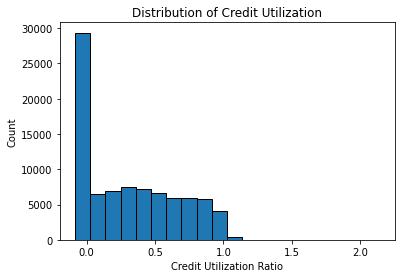

In [ ]:
plt.hist(app_train_data['credit_util'], edgecolor = 'k', bins=20)
plt.title('Distribution of Credit Utilization')
plt.xlabel('Credit Utilization Ratio')
plt.ylabel('Count')

[Text(0.5, 1.0, 'Distribution Work History by Gender'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Work History to Age Ratio')]

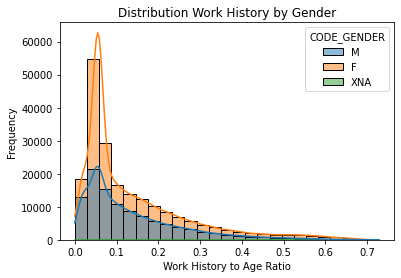

In [ ]:
#app_train_data_g = app_train_data[app_train_data['CODE_GENDER']!='XNA']

#sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data = app_train_data, x="work_history", bins=25, hue="CODE_GENDER",kde = True).set(
    title = "Distribution Work History by Gender",
    ylabel = "Frequency",
    xlabel = "Work History to Age Ratio")

## Running Pipeline with new Features

In [4]:
import pandas as pd

app_train_joined = pd.read_csv('/content/app_train_joined.csv')
new_features = ['work_history',
'inc_loan_ratio',
'prev_loans',
'dwn_pymt_pct',
'DAYS_LATE_PAYMENT',
'AMT_LATE_PAYMENT' ]

#filling the missing value
app_train_joined['prev_loans'].fillna(value = 0, inplace = True)
app_train_joined['dwn_pymt_pct'].fillna(value = 0, inplace = True)
app_train_joined['DAYS_LATE_PAYMENT'].fillna(value = 0, inplace = True)
app_train_joined['AMT_LATE_PAYMENT'].fillna(value = 0, inplace = True)

app_train_joined[new_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   work_history       307511 non-null  float64
 1   inc_loan_ratio     307511 non-null  float64
 2   prev_loans         307511 non-null  float64
 3   dwn_pymt_pct       307511 non-null  float64
 4   DAYS_LATE_PAYMENT  307511 non-null  float64
 5   AMT_LATE_PAYMENT   307511 non-null  float64
dtypes: float64(6)
memory usage: 14.1 MB


### Baseline Model

In [5]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split  # sklearn.cross_validation in old versions
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)


In [6]:

data = app_train_joined
y = data['TARGET']
selected_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','CNT_FAM_MEMBERS',
                      'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                      'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE',
                      'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                      'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                      'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','REGION_RATING_CLIENT',
                      'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE',
                      'work_history','inc_loan_ratio','prev_loans','dwn_pymt_pct','DAYS_LATE_PAYMENT','AMT_LATE_PAYMENT']
X = data[selected_features]

# Split the provided training data into training and validationa and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,shuffle=True, random_state=42)

print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

# Identify the numeric features we wish to consider. 
numerical_selected_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','CNT_FAM_MEMBERS',
                      'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                      'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE',
                      'work_history','inc_loan_ratio','prev_loans','dwn_pymt_pct','DAYS_LATE_PAYMENT','AMT_LATE_PAYMENT'
]


num_pipeline =Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])
                

# Identify the categorical features we wish to consider.
categorical_selected_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                        'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','REGION_RATING_CLIENT',
                        'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                        'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE'
]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])


data_pipeline = ColumnTransformer(transformers=[
        ("num_pipeline", num_pipeline, numerical_selected_features),
        ("cat_pipeline", cat_pipeline, categorical_selected_features)],
        remainder='drop',
        n_jobs=-1
    )


X train           shape: (209107, 49)
X validation      shape: (52277, 49)
X test            shape: (46127, 49)


In [7]:
clf_nf = Pipeline([
    ('data_prep',data_pipeline),
    ('clf_nf',LogisticRegression(solver='lbfgs', max_iter=1000))])
# Time and score test predictions
start = time()
clf_nf.fit(X_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
trainAcc  = clf_nf.score(X_train, y_train)
#cv20Splits = ShuffleSplit(n_splits=30, test_size=0.2,random_state=42)
#validAcc = cross_val_score(data_pipeline,X_valid, y_valid, cv=cv20Splits)
#validAcc = validAcc.mean()
validAcc  = clf_nf.score(X_valid, y_valid)
start = time()
testAcc  = clf_nf.score(X_test, y_test)
test_time = np.round(time() - start, 4)
trainAUC = roc_auc_score(y_train, clf_nf.predict_proba(X_train)[:, 1])
validAUC = roc_auc_score(y_valid, clf_nf.predict_proba(X_valid)[:, 1])
testAUC = roc_auc_score(y_test, clf_nf.predict_proba(X_test)[:, 1])

In [8]:
try:
    result1
except NameError:
    result1 = pd.DataFrame(columns=["exp_name", "TrainAcc", "ValidAcc", "TestAcc", "TrainAUC", "ValidAUC",
                                   "TestAUC", "Train Time(s)",  "Test Time(s)", "Description"])

result1.loc[0] = ["Baseline with new features", np.round(pct(trainAcc),3), np.round(pct(validAcc),3), np.round(pct(testAcc),3),
                  np.round(pct(trainAUC),3), np.round(pct(validAUC),3),np.round(pct(testAUC),3), train_time, test_time, "Untuned LogisticRegression"]
result1


exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression

## Trying different Models with New Features

In [ ]:
#!pip install hyperopt

### LGBM Model

In [ ]:
#!pip install lightgbm

     |████████████████████████████████| 2.0 MB 2.8 MB/s            
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import sklearn.tree as tree
import xgboost as xgb
import lightgbm as lgb

model_LGBM = Pipeline([
    ('data_prep',data_pipeline),
    ('clf_LGBM',lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1))])

# Time and score test predictions
start = time()
model_LGBM.fit(X_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
trainAcc  = model_LGBM.score(X_train, y_train)
#cv20Splits = ShuffleSplit(n_splits=30, test_size=0.2,random_state=42)
#validAcc = cross_val_score(data_pipeline,X_valid, y_valid, cv=cv20Splits)
#validAcc = validAcc.mean()
validAcc  = model_LGBM.score(X_valid, y_valid)
start = time()
testAcc  = model_LGBM.score(X_test, y_test)
test_time = np.round(time() - start, 4)
trainAUC = roc_auc_score(y_train, model_LGBM.predict_proba(X_train)[:, 1])
validAUC = roc_auc_score(y_valid, model_LGBM.predict_proba(X_valid)[:, 1])
testAUC = roc_auc_score(y_test, model_LGBM.predict_proba(X_test)[:, 1])

In [10]:
result1.loc[1] = ["lightgbm", np.round(pct(trainAcc),3), np.round(pct(validAcc),3), np.round(pct(testAcc),3),
                  np.round(pct(trainAUC),3), np.round(pct(validAUC),3),np.round(pct(testAUC),3), train_time, test_time, "lightgbm model"]
result1

exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   
1                    lightgbm      73.6      72.4     71.8      82.6   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression  
1      76.1     76.0       118.1258        6.2748              lightgbm model

### CatBoost

In [12]:
#!pip install catboost

     |████████████████████████████████| 76.6 MB 62 kB/s 


In [13]:
from catboost import CatBoostClassifier

model_catboost = Pipeline([
    ('data_prep',data_pipeline),
    ('clf_catboost',CatBoostClassifier())])

# Time and score test predictions
start = time()
model_catboost.fit(X_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
trainAcc  = model_catboost.score(X_train, y_train)
#cv20Splits = ShuffleSplit(n_splits=30, test_size=0.2,random_state=42)
#validAcc = cross_val_score(data_pipeline,X_valid, y_valid, cv=cv20Splits)
#validAcc = validAcc.mean()
validAcc  = model_catboost.score(X_valid, y_valid)
start = time()
testAcc  = model_catboost.score(X_test, y_test)
test_time = np.round(time() - start, 4)
trainAUC = roc_auc_score(y_train, model_catboost.predict_proba(X_train)[:, 1])
validAUC = roc_auc_score(y_valid, model_catboost.predict_proba(X_valid)[:, 1])
testAUC = roc_auc_score(y_test, model_catboost.predict_proba(X_test)[:, 1])

Learning rate set to 0.100863
0:	learn: 0.5924059	total: 121ms	remaining: 2m
1:	learn: 0.5180870	total: 189ms	remaining: 1m 34s
2:	learn: 0.4563499	total: 260ms	remaining: 1m 26s
3:	learn: 0.4105694	total: 333ms	remaining: 1m 22s
4:	learn: 0.3761630	total: 398ms	remaining: 1m 19s
5:	learn: 0.3492624	total: 464ms	remaining: 1m 16s
6:	learn: 0.3295423	total: 533ms	remaining: 1m 15s
7:	learn: 0.3143565	total: 599ms	remaining: 1m 14s
8:	learn: 0.3014591	total: 663ms	remaining: 1m 12s
9:	learn: 0.2917029	total: 729ms	remaining: 1m 12s
10:	learn: 0.2838074	total: 805ms	remaining: 1m 12s
11:	learn: 0.2782849	total: 883ms	remaining: 1m 12s
12:	learn: 0.2733670	total: 948ms	remaining: 1m 11s
13:	learn: 0.2696032	total: 1.02s	remaining: 1m 12s
14:	learn: 0.2664208	total: 1.09s	remaining: 1m 11s
15:	learn: 0.2637050	total: 1.16s	remaining: 1m 11s
16:	learn: 0.2616428	total: 1.22s	remaining: 1m 10s
17:	learn: 0.2596611	total: 1.3s	remaining: 1m 10s
18:	learn: 0.2580408	total: 1.37s	remaining: 1m 1

In [14]:
result1.loc[2] = ["catboost", np.round(pct(trainAcc),3), np.round(pct(validAcc),3), np.round(pct(testAcc),3),
                  np.round(pct(trainAUC),3), np.round(pct(validAUC),3),np.round(pct(testAUC),3), train_time, test_time, "catboost model"]
result1

exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   
1                    lightgbm      73.6      72.4     71.8      82.6   
2                    catboost      92.7      91.6     91.9      83.6   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression  
1      76.1     76.0       118.1258        6.2748              lightgbm model  
2      76.1     76.1        91.8952        3.1409              catboost model

### RandomForest

In [15]:
model_RF = Pipeline([
    ('data_prep',data_pipeline),
    ('clf_RF',RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10,class_weight='balanced',
                                      random_state=42, n_jobs=-1))])


# Time and score test predictions
start = time()
model_RF.fit(X_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
trainAcc  = model_RF.score(X_train, y_train)
#cv20Splits = ShuffleSplit(n_splits=30, test_size=0.2,random_state=42)
#validAcc = cross_val_score(data_pipeline,X_valid, y_valid, cv=cv20Splits)
#validAcc = validAcc.mean()
validAcc  = model_RF.score(X_valid, y_valid)
start = time()
testAcc  = model_RF.score(X_test, y_test)
test_time = np.round(time() - start, 4)
trainAUC = roc_auc_score(y_train, model_RF.predict_proba(X_train)[:, 1])
validAUC = roc_auc_score(y_valid, model_RF.predict_proba(X_valid)[:, 1])
testAUC = roc_auc_score(y_test, model_RF.predict_proba(X_test)[:, 1])

In [16]:
result1.loc[3] = ["Random forest", np.round(pct(trainAcc),3), np.round(pct(validAcc),3), np.round(pct(testAcc),3),
                  np.round(pct(trainAUC),3), np.round(pct(validAUC),3),np.round(pct(testAUC),3), train_time, test_time, "Random forest model"]
result1

exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   
1                    lightgbm      73.6      72.4     71.8      82.6   
2                    catboost      92.7      91.6     91.9      83.6   
3               Random forest      72.1      70.9     70.8      78.6   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression  
1      76.1     76.0       118.1258        6.2748              lightgbm model  
2      76.1     76.1        91.8952        3.1409              catboost model  
3      72.5     73.0         9.5963        1.0675         Random forest model

### XGBoost

In [17]:
model_XGB = Pipeline([
    ('data_prep',data_pipeline),
    ('clf_XGB',xgb.XGBClassifier(random_state=1,learning_rate=0.01))])

# Time and score test predictions
start = time()
model_XGB.fit(X_train, y_train)
train_time = np.round(time() - start, 4)
np.random.seed(42)
trainAcc  = model_XGB.score(X_train, y_train)
#cv20Splits = ShuffleSplit(n_splits=30, test_size=0.2,random_state=42)
#validAcc = cross_val_score(data_pipeline,X_valid, y_valid, cv=cv20Splits)
#validAcc = validAcc.mean()
validAcc  = model_XGB.score(X_valid, y_valid)
start = time()
testAcc  = model_XGB.score(X_test, y_test)
test_time = np.round(time() - start, 4)
trainAUC = roc_auc_score(y_train, model_XGB.predict_proba(X_train)[:, 1])
validAUC = roc_auc_score(y_valid, model_XGB.predict_proba(X_valid)[:, 1])
testAUC = roc_auc_score(y_test, model_XGB.predict_proba(X_test)[:, 1])

In [18]:
result1.loc[4] = ["XGBoost", np.round(pct(trainAcc),3), np.round(pct(validAcc),3), np.round(pct(testAcc),3),
                  np.round(pct(trainAUC),3), np.round(pct(validAUC),3),np.round(pct(testAUC),3), train_time, test_time, "XGBoost model"]
result1

exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   
1                    lightgbm      73.6      72.4     71.8      82.6   
2                    catboost      92.7      91.6     91.9      83.6   
3               Random forest      72.1      70.9     70.8      78.6   
4                     XGBoost      92.0      91.6     91.9      70.9   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression  
1      76.1     76.0       118.1258        6.2748              lightgbm model  
2      76.1     76.1        91.8952        3.1409              catboost model  
3      72.5     73.0         9.5963        1.0675         Random forest model  
4      70.4     70.5       123.7200        2.0138               XGBoost model

## Hyperparameter Tuning: Finding Best Params

__OPTIONAL__: We are using Hyperopt package for tuning as GridSearch was taking very long than expected. Got this piece of Code online as an alternative to Grid Search Module which was taking a very long time to run both on local and Google Colab. Modified the below further to fit our model and the parameters that need to tuned.

### Hyperopt Package

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lg

def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': '{:.3f}'.format(params['subsample']),
    }

    clf = lg.LGBMClassifier(
        n_jobs=-1,
        **params
    )

    gbm_model = clf.fit(X_train, y_train
                        ,eval_set=[(X_valid, y_valid)]
                        ,eval_metric=['logloss', 'auc']
                        ,early_stopping_rounds=50, verbose=False)

    predictions = gbm_model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, predictions)

    return {'loss': 1-score, 'status': STATUS_OK}


space = {
    'n_estimators': hp.quniform('n_estimators', 500, 2000, 100),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'reg_alpha': hp.quniform('reg_alpha', 0.0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.0, 1, 0.1), 
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)
print(best)

100%|██████████| 30/30 [05:42<00:00, 11.42s/trial, best loss: 0.23664075981635002]
{'colsample_bytree': 0.4, 'learning_rate': 0.025, 'max_depth': 5.0, 'min_child_weight': 6.0, 'n_estimators': 1300.0, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.65}


Previous Run Parameters:
{'colsample_bytree': 0.30000000000000004, 'learning_rate': 0.1, 'max_depth': 2.0, 'min_child_weight': 6.0, 'n_estimators': 1800.0, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.65}

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'max_depth': int(params['max_depth']),
    }

    clf = xgb.XGBClassifier(
        n_jobs=-1,
        **params
    )

    xgb_model = clf.fit(X_train, y_train
                        ,eval_set=[(X_valid, y_valid)]
                        ,eval_metric=['logloss', 'auc']
                        ,early_stopping_rounds=50, verbose=False)

    predictions = xgb_model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, predictions)

    return {'loss': 1-score, 'status': STATUS_OK}


space = {
    'n_estimators': hp.quniform('n_estimators', 500, 2000, 100),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.025),
    'min_child_weight': hp.quniform('min_child_weight', 20, 35, 5),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'reg_alpha': hp.quniform('reg_alpha', 0.0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.0, 1, 0.1), 
    'max_depth': hp.quniform('max_depth', 3, 8, 1), 
}

'''
    classifiers = [
        ('XGBoost', xgb.XGBClassifier(random_state = 42)),
        ('LightGBM', lgb.LGBMClassifier(random_state=42)),
    ]

    # Arrange grid search parameters for each classifier

    params_grid = {
        
        'XGBoost':  {
            'n_estimators' : [500, 1000], 
            'eta': [0.01, 0.05, 0.1],
            'min_child_weight' : [20, 35],
            'colsample_bytree': [0.8, 0.95],
#             'reg_alpha'  : [0.01, 0.05, 0.1],
#             'reg_lambda' : [0.01, 0.05, 0.1],
            'max_depth' : [3,6,8],
            'verbosity': [0],
            'verbose_eval': [False],
'''

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)
print(best)

100%|██████████| 30/30 [18:05<00:00, 36.18s/trial, best loss: 0.2357839333477767] 
{'colsample_bytree': 0.4, 'learning_rate': 0.025, 'max_depth': 6.0, 'min_child_weight': 30.0, 'n_estimators': 1900.0, 'reg_alpha': 0.8, 'reg_lambda': 0.1, 'subsample': 0.9500000000000001}


### Grid Search
In the previous submission, we couldn't tune hyperparameter with grid search. Since the due day extension, we have more time with grid search. However, we could not put more estimators or parameters as the training set too large. We choose LightGBM with 'learning_rate': [0.01, 0.1], 'reg_alpha': [0.01, 0.05], and 3 folds. That yields the result. We will find solutions to put more estimators and parameters with grid search. 

In [19]:
from sklearn.model_selection import GridSearchCV

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_pipeline),
        ("LightGBM", lgb.LGBMClassifier(random_state=42))
        ])
params = {'LightGBM__learning_rate': [0.01, 0.1], 'LightGBM__reg_alpha': [0.01, 0.05]}

grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
# Best estimator score
best_train = pct(grid_search.best_score_)

# Best estimator fitting time
start = time()
grid_search.best_estimator_.fit(X_train, y_train)
best_train_accuracy = pct(grid_search.best_estimator_.score(X_train, y_train))
train_time = round(time() - start, 4)
best_validation_accuracy = pct(grid_search.best_estimator_.score(X_valid, y_valid))
# Best estimator prediction time
start = time()
best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
test_time = round(time() - start, 4)
best_trainAUC = roc_auc_score(y_train, grid_search.best_estimator_.predict_proba(X_train)[:, 1])
best_validAUC = roc_auc_score(y_valid, grid_search.best_estimator_.predict_proba(X_valid)[:, 1])
best_testAUC = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [20]:
result1.loc[5] = ["Model with gridsearch", best_train_accuracy, best_validation_accuracy, best_test_accuracy,
                  np.round(pct(trainAUC),3), np.round(pct(best_validAUC),3),np.round(pct(best_testAUC),3), train_time, test_time,"Tuning LightGBM"]

In [21]:
print(grid_search.best_estimator_)

Pipeline(steps=[('preparation',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
     

In [22]:
result1

exp_name  TrainAcc  ValidAcc  TestAcc  TrainAUC  \
0  Baseline with new features      92.0      91.6     91.9      74.8   
1                    lightgbm      73.6      72.4     71.8      82.6   
2                    catboost      92.7      91.6     91.9      83.6   
3               Random forest      72.1      70.9     70.8      78.6   
4                     XGBoost      92.0      91.6     91.9      70.9   
5       Model with gridsearch      92.1      91.6     92.0      70.9   

   ValidAUC  TestAUC  Train Time(s)  Test Time(s)                 Description  
0      74.9     74.6        77.9337        1.0247  Untuned LogisticRegression  
1      76.1     76.0       118.1258        6.2748              lightgbm model  
2      76.1     76.1        91.8952        3.1409              catboost model  
3      72.5     73.0         9.5963        1.0675         Random forest model  
4      70.4     70.5       123.7200        2.0138               XGBoost model  
5      75.9     75.8        20.3034        1.3441             Tuning LightGBM

## Phase 2 - Kaggle Submission

In [23]:
import pandas as pd 
app_test_joined = pd.read_csv('/content/app_test_joined.csv') 
app_test_joined['prev_loans'].fillna(value = 0, inplace = True)
app_test_joined['dwn_pymt_pct'].fillna(value = 0, inplace = True)
app_test_joined['DAYS_LATE_PAYMENT'].fillna(value = 0, inplace = True)
app_test_joined['AMT_LATE_PAYMENT'].fillna(value = 0, inplace = True)

### LightGBM Model

In [24]:
data_test = app_test_joined
print(data_test.shape)
selected_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','CNT_FAM_MEMBERS',
                      'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                      'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE',
                       'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                      'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                      'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
                      'OCCUPATION_TYPE',
                      'REGION_RATING_CLIENT',
                      'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY'
                      ,'ORGANIZATION_TYPE'
                       ,'work_history','inc_loan_ratio','prev_loans','dwn_pymt_pct','DAYS_LATE_PAYMENT','AMT_LATE_PAYMENT']
X_Kaggle_test = data_test[selected_features]

(48744, 129)


In [25]:
test_class_scores = model_LGBM.predict_proba(X_Kaggle_test)[:, 1]

submit_df = app_test_joined[['SK_ID_CURR']]
submit_df['TARGET'] = test_class_scores

submit_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


SK_ID_CURR    TARGET
0      100001  0.097908
1      100005  0.631691
2      100013  0.230785
3      100028  0.111489
4      100038  0.538529

In [26]:
submit_df.to_csv("/content/lgbm_model_submission.csv",index=False)

### CatBoost Model

In [27]:
test_class_scores = model_catboost.predict_proba(X_Kaggle_test)[:, 1]

submit_df = app_test_joined[['SK_ID_CURR']]
submit_df['TARGET'] = test_class_scores

submit_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


SK_ID_CURR    TARGET
0      100001  0.031769
1      100005  0.083637
2      100013  0.057341
3      100028  0.025707
4      100038  0.326808

In [28]:
submit_df.to_csv("/content/catboost_model_submission.csv",index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Write-up

## Group members

Sai Varun Datta Vemavarapu savemava@iu.edu 

Binh Bui binbui@iu.edu

Kevaun Stewart kevstew@iu.edu

Prasad Yacham pyacham@iu.edu

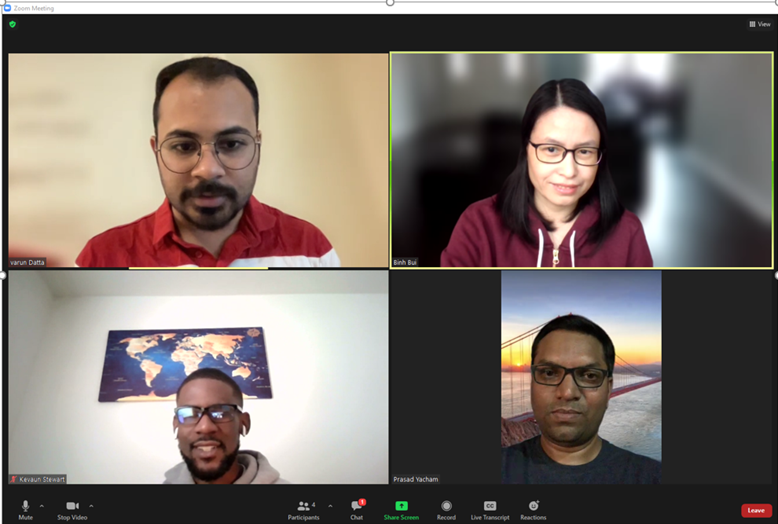

## Abstract

This project involves working on the dataset provided on Kaggle by Home Credit, a financial institution to assess and minimize the default rate for a home loan and improve the experience of customers with zero to minimal credit history.
The dataset provided has several records including the POS sales, cash loans and loans for products through online and physical distribution networks. 

In this phase, we perform feature engineering on all the datasets. We extract the new features, created new training set, and implement our baseline model on it. Later, to find the best model, we implement LightGBM, RandomForest, CatBoost and XGBoost models with the new training set. We tune the hyperparameters of the models using Grid Search. We use the ROC_AUC score to evaluate the models.

At the end, we see that the results obtained from the experiment performed by LightGBM yielded best result in overall. The idea is to improve the accuracy while keeping the model as simple as possible.


## Project Description

* __Data description__: See section *1.1 Dataset*


* __Task to be tackled__:

    - Do the research with all tables of the dataset
    - Develop new features: work_history, inc_loan_ration, prev_loans, dwn_pymt_pct, DAYS_TALE_PAYMENT, AMT_LATE_PAYMENT   
    - Build the processing pipeline
    - Run the baseline model with the new features
    - Do experiments with LGBM, CatBoost, RandomForest, XGBoost
    - Conduct hyperparameter tuning with LGBM using GridSearchCV
    - Evaluate models and discuss results
    - Choose our best model
    - Submit on Kaggle


* __Workflow__: 
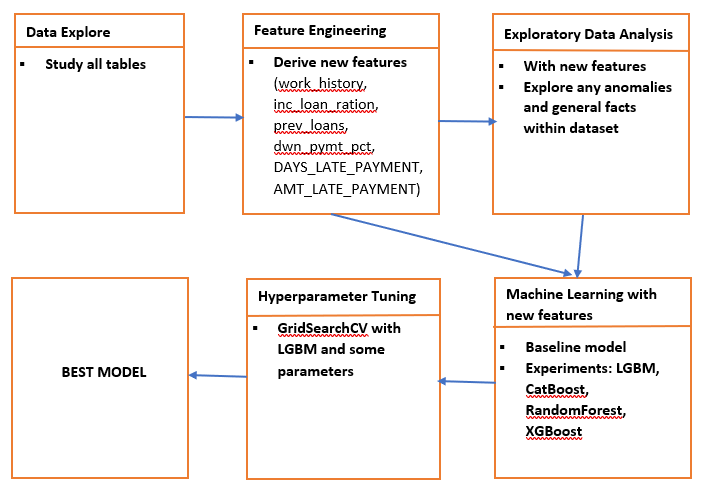


## Feature Engineering

We have studied all table of the dataset and derived 6 new features from tables: __application_train, previous_application, and installments_payments__. (see section 1.2 for detail calculation)

6 derived features: 

__Work history (‘work_history’)__: days employed divided by days birth; implies how long an applicant’s work history is as a ratio of their total age. The higher the ratio, the longer the applicant has been working in their life. 

__Inc_loan ratio ('inc_loan_ratio')__: applicant’s income divided by the granted loan amount. We use this to gauge if the applicant is borrowing too much – the smaller the ratio, the more the applicant is borrowing compared to their income. 

__Previous loans ('prev_loans')__: a count of previous loans recorded by Home Credit bureau. We are curious to see the impact (positive or negative) to prediction using this feature. 

__Down payment percentage ('dwn_pymt_pct')__: Average down payment on previous Home Credit loans divided by average amount of previous Home Credit Loans received. We use this feature to gauge if higher down payments on loan will impact if an applicant defaults or not. 

__Number of late payments(‘DAYS_LATE_PAYMENT’)__: count the number of late payment of each borrower on previous Home Credit loans from the installments_payment table. The higher this number, the more likely that the borrower struggles with the repayment.

__Amount of late payments (‘AMT_LATE_PAYMENT’)__: the total amount of late payment of each borrower on previous Home Credit loans from the installments_payment table. The higher this number, the more likely that the borrower gets default.


## Hyperparameter Tuning

* In the previous submission, we couldn't tune hyperparameter with grid search. Since the due day extension, we have more time with grid search. However, we could not put more estimators or parameters as the training set too large. We choose LightGBM with 'learning_rate': [0.01, 0.1], 'reg_alpha': [0.01, 0.05], and 3 folds. That yields the result. We will find solutions to put more estimators and parameters with grid search. 

* The best estimator with grid search:

```python
Pipeline(steps=[('preparation',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID...
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_PHONE', 'FLAG_EMAIL',
                                                   'OCCUPATION_TYPE',
                                                   'REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'REG_REGION_NOT_WORK_REGION',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'LIVE_CITY_NOT_WORK_CITY',
                                                   'ORGANIZATION_TYPE'])])),
                ('LightGBM', LGBMClassifier(random_state=42, reg_alpha=0.05))])
```

* __OPTIONAL__: We are using Hyperopt package for tuning as GridSearch was taking very long than expected. Got this piece of Code online as an alternative to Grid Search Module which was taking a very long time to run both on local and Google Colab. Modified the below further to fit our model and the parameters that need to tuned.

    Note: Found hyperopt tuning code online over internet over multiple references. Forgot to note the references.
  

## Modeling Pipelines

In phase 2, we use binomial Logistic Regression for our baseline models with the objective function (log loss function) as follow:

$$
\underset{\mathbf{\theta}}{\operatorname{argmin}}\left[\text{CXE}\right] = \underset{\mathbf{\theta}}{\operatorname{argmin}} \left[ -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} \right] $$

Here is our pipeline diagram:

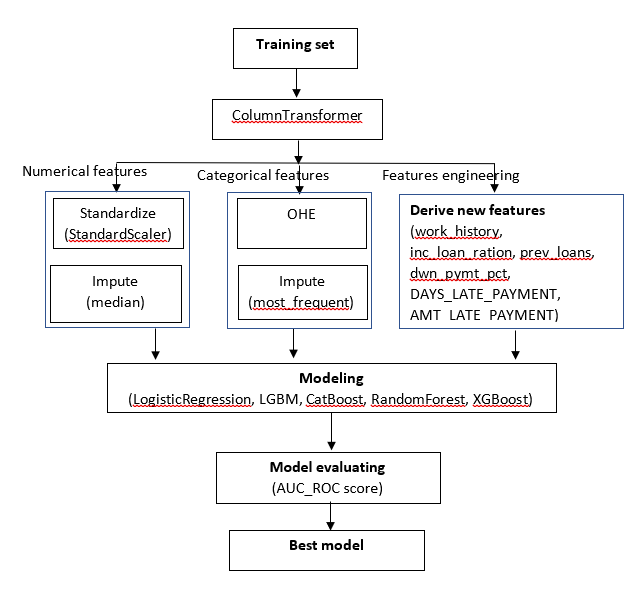

* The baseline model 43 raw features from aplication_train table and 6 new features derived from tables: application_train, previous_application, and installments_payments. 

__The new features:__
```python
newfeatures = ['work_history', 'inc_loan_ratio', 'prev_loans', 'dwn_pymt_pct',
             'DAYS_LATE_PAYMENT','AMT_LATE_PAYMENT']
```

__The numerical features:__
```python
numerical_selected_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'work_history', 'inc_loan_ratio', 'prev_loans', 'dwn_pymt_pct', 'DAYS_LATE_PAYMENT', 'AMT_LATE_PAYMENT']
```
__The categorical features:__
```python
categorical_selected_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE' ,'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE']
```

* We have created 4 experiments with the numerical and categorical features above using ensemble methods: __LGBM, CatBoost, RandomForest, XGBoost__ 


## Evaluation metric
__Area Under the Curve-Receiver Operating Characteristics (AUC-ROC) score__ will be used to evaluate the accuracy of various logistic regression models (based on varying hyperparameters and thresholds). The AUC score represents the area under the ROC graph. The ROC graph represents a plot of the True Positive Rate (TPR) versus the False Positive Rate (FPR) – where each point on the graph represents a different logistic regression model. The higher the AUC-ROC score, the better. TPR and FPR are defined in equations 1 and 2, respectively.  

__Equation 1:__

*True Positive Rate, TPR = True Positives / (True Positives + False Negatives)*

Where: 

    True Positives = samples accurately classified as class 1 (class 1 = will default on loan) 

    False Negatives = samples incorrectly classified as class 0 (class 0 = will not default on loan) 

__Equation 2:__

*False Positive Rate, FPR = False Positives / (True Negatives + False Positives)* 

Where: 

    False Positives = samples incorrectly classified as class 1 

    True Negatives = samples accurately classified as class 0 


## Experimental results

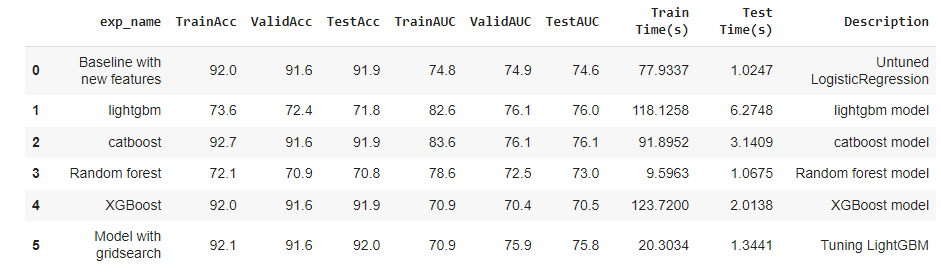

## Kaggle Submission

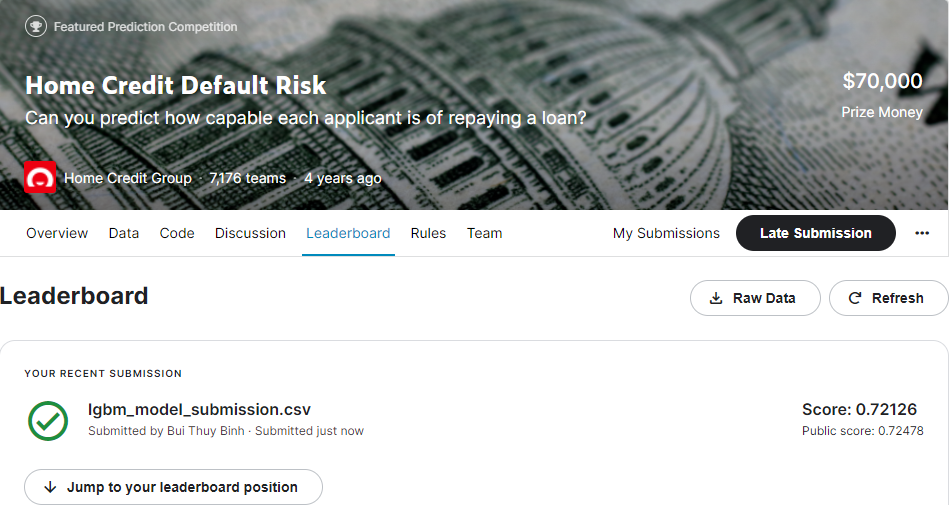

## Discussion
__We have derived 6 new features from application_train, previous_application, and installments_payments tables__
They are *'work_history', 'inc_loan_ratio', 'prev_loans', 'dwn_pymt_pct', 'DAYS_LATE_PAYMENT', and 'AMT_LATE_PAYMENT'*

We applied these new features in to our baseline model from Phase 1, and the test AUC score has improved from 0.7423 to 0.746

__We have conducted 4 experiments with LGBM, CatBoost, RandomForest, XGBoost__ to see if we have better result:

* CatBoost has the highest result in our notebook with 76.1% of test AUC. Next is LightGBM with 76% test AUC in our notebook. RandomForest gets the third position with 73% of test AUC. Last is XGBoost with 70.5% of test AUC.

__Hyperparameter tuning with GridSearchCV__: We could not put more estimators or parameters as the training set too large .Uur computer and Google Colab cannot run grid search with so many fits. We choose LightGBM with 'learning_rate': [0.01, 0.1], 'reg_alpha': [0.01, 0.05], and 3 folds. That yields the result of 75.8% test AUC of the best estimator. We will find solutions to put more estimators and parameters with grid search. 

__Kaggle Submission:__

We create Kaggle submission file2 with LightGBM and CatBoost. LightGBM got higher score with public score at 0.72478 and private scores at 0.72126.

__Overall:__

With all our experiments we have created, CatBoost has the highest test AUC in our notebook (0.761). While in Kaggle, LightGBM gets better score than CatBoost (below 0.7).

__Problems:__

As the dataset is very complicated and large, also with the time constraint we could not check all the features.

GridSearch was taking a long time because of huge dataset and computer limitations. So, initially we could not run it. Later, we can perform some parameters with grid search for LightGBM model. However, even after hyperparameter tuning, we could not see much progress


## Conclusion

In this phase we checked all the tables of the dataset and derived 6 new features from these tables. We applied these new features in to our baseline model, and the test AUC score has improved from 0.7423 to 0.746 

Later we have built 4 more modeling pipelines using LGBM, CatBoost, RandomForest, XGBoost and done hyperparameter tuning with grid search. We have compared all the training, testing accuracies, Kaggle scores, and chosen our best model which is LGBM without tuning.

The best model, LGBM has the highest test AUC in our notebook (0.761) with Kaggle score of 0.72478

All experiments we have conducted in phase 1 and phase 2, the model using LGBM has yielded the best test AUC scores in our notebook. Adding new features and hyperparameter tuning have helped in predicting the target variable based on our notebook experiments. 

For the next phase, we will implement a Deep learning model. Build a multi-layer perception model in PyTorch for loan default classification. As a stretch goal, we will develop and implement and new multitask loss function in PyTorch.